Where I try to make a variational auto encoder (VAE) that fits makehuman data.

Goal: find if it's faster and takes less memory to use a fitted model, that the normal morphtargets. The morphtargets are linear interp so probobly not but we will see. There may also be additional side effects to this, and I could ask humans to classify the models to possibly get more accurate labels.

In [1]:
import keras
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


ImportError: No module named tensorflow

# load data

The consistent of:
- X the delta on each vertice (base vertices as in basemodel.json)
- y: the parameters used to generate the vertices (param labels are in metadata.json)

In [3]:
# load
from path import Path
data_path = Path('../data/20161117-193527_None_vae_data')

from keras.utils.io_utils import HDF5Matrix

# split into validation data
X_train = HDF5Matrix(data_path.joinpath('X_train.hdf5'), 'data')
val_indice = int(len(X_train)*0.8)
test_indice = int(len(X_train)*0.9)

X_train = HDF5Matrix(data_path.joinpath('X_train.hdf5'), 'data', start=0, end=val_indice)
y_train = HDF5Matrix(data_path.joinpath('y_train.hdf5'), 'data', start=0, end=val_indice)
X_val = HDF5Matrix(data_path.joinpath('X_train.hdf5'), 'data', start=val_indice, end=test_indice)
y_val = HDF5Matrix(data_path.joinpath('y_train.hdf5'), 'data', start=val_indice, end=test_indice)
X_test = HDF5Matrix(data_path.joinpath('X_train.hdf5'), 'data', start=test_indice, end=None)
y_test = HDF5Matrix(data_path.joinpath('y_train.hdf5'), 'data', start=test_indice, end=None)

In [4]:
import json
metadata = json.load(open(data_path.joinpath('metadata.json')))

modifier_names = sorted([(int(k),v) for k,v in metadata['target_dict'].items()])
modifier_names = [row[1] for row in modifier_names]

X_train.shape, y_train.shape, len(modifier_names)

((7903, 19158, 3), (7903, 249), 249)

In [5]:
nb_targets = len(modifier_names)
nb_vertices = X_train.shape[1]
nb_dims = 3
hidden_dims = 107*3
batch_size = 32
nb_targets

249

In [6]:
# tensorflow wants it to split evenly into nice batch sizes
train_crop = X_train.shape[0]%batch_size
X_train.end-=train_crop
y_train.end-=train_crop

val_crop = X_val.shape[0]%batch_size
X_val.end-=val_crop
y_val.end-=val_crop

test_crop = X_test.shape[0]%batch_size
X_test.end-=test_crop
y_test.end-=test_crop

assert X_train.shape[0]%batch_size==0
assert y_train.shape[0]%batch_size==0
assert X_test.shape[0]%batch_size==0
assert y_test.shape[0]%batch_size==0
assert X_val.shape[0]%batch_size==0
assert y_val.shape[0]%batch_size==0

# Define model


In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape, InputLayer, Permute, RepeatVector, Dropout, LocallyConnected1D
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from PIL import Image
import math

In [10]:
from keras.layers import (Input, LocallyConnected1D, ZeroPadding1D, Cropping1D, Embedding, Merge, merge,
    Cropping2D, Convolution1D, Convolution2D, Deconvolution2D, BatchNormalization, UpSampling1D, RepeatVector)
from keras.layers import embeddings, convolutional, activations, normalization, advanced_activations
from keras.models import Model

In [44]:
# simple 1 layer dense model gives 0.97 acc
x = input =  Input((nb_targets,), name='input')

x = Dense(nb_targets)(x)
x = advanced_activations.LeakyReLU(0.3)(x)

x = Dense(nb_targets)(x)
x = advanced_activations.LeakyReLU(0.3)(x)

x = Dense(nb_vertices*3)(x)
x = advanced_activations.LeakyReLU(0.3)(x)

x = Reshape((nb_vertices,3),name='output')(x)

generator = Model(input,x)

generator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 249)           0                                            
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 249)           62250       input[0][0]                      
____________________________________________________________________________________________________
leakyrelu_4 (LeakyReLU)          (None, 249)           0           dense_4[0][0]                    
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 249)           62250       leakyrelu_4[0][0]                
___________________________________________________________________________________________

In [45]:
output_dir = Path('../outputs/'+data_path.name)
output_dir.makedirs_p()
output_dir

Path('../outputs/20161117-193527_None_vae_data')

In [46]:
import arrow
ts = arrow.utcnow().format('YYYY-MM-DD_HH-mm-ss')

In [47]:
# pretrain/test
generator.compile(loss='mae',optimizer='nadam', metrics=['accuracy'])
history = generator.fit(
    y_train,X_train,
    verbose=1, nb_epoch=200, batch_size=batch_size,
              validation_data=[y_val, X_val], shuffle='batch',
              callbacks=[
                    keras.callbacks.EarlyStopping(patience=9, monitor='loss'),
                    keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=3, verbose=1),
                    keras.callbacks.ModelCheckpoint(output_dir.joinpath('model.hdf5'), save_best_only=True),
                    keras.callbacks.CSVLogger(output_dir.joinpath('log-%s.log'%ts)),
                    keras.callbacks.TensorBoard(log_dir=output_dir),
                    

                ]
             )

Train on 7872 samples, validate on 960 samples
Epoch 1/200
7872/7872 [==============================] - 46s - loss: 0.9615 - acc: 0.4410 - val_loss: 1.2820 - val_acc: 0.4045
Epoch 2/200
7872/7872 [==============================] - 42s - loss: 0.7160 - acc: 0.6305 - val_loss: 0.8061 - val_acc: 0.5855
Epoch 3/200
7872/7872 [==============================] - 36s - loss: 0.5571 - acc: 0.7282 - val_loss: 0.5229 - val_acc: 0.7638
Epoch 4/200
7872/7872 [==============================] - 35s - loss: 0.4935 - acc: 0.7671 - val_loss: 0.4373 - val_acc: 0.8226
Epoch 5/200
7872/7872 [==============================] - 33s - loss: 0.4507 - acc: 0.7833 - val_loss: 0.4116 - val_acc: 0.8311
Epoch 6/200
7872/7872 [==============================] - 24s - loss: 0.4237 - acc: 0.7973 - val_loss: 0.5282 - val_acc: 0.7930
Epoch 7/200
7872/7872 [==============================] - 25s - loss: 0.3770 - acc: 0.8140 - val_loss: 0.3045 - val_acc: 0.8647
Epoch 8/200
7872/7872 [==============================] - 24s - l

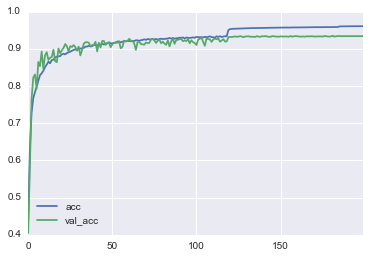

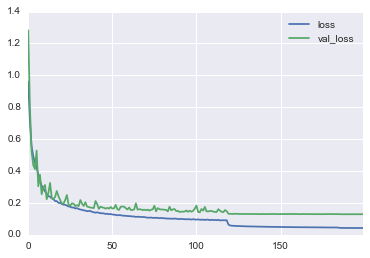

In [48]:
df = pd.DataFrame.from_dict(history.history)
df[['acc','val_acc']].plot()
plt.show()
df[['loss','val_loss']].plot()

In [50]:
score = generator.evaluate(y_test,X_test, verbose=1, batch_size=batch_size)
score = dict(zip(generator.metrics_names,score))
score

960/960 [==============================] - 2s     


{'acc': 0.92633376916249588, 'loss': 0.12936650961637497}

In [51]:
model_file=output_dir.joinpath('model_acc_%2.2f_date_%s.hdf'%(score['acc'],ts))
generator.save(model_file)
model_file

Path('../outputs/20161117-193527_None_vae_data/model_acc_0.93_date_2016-11-17_23-49-51.hdf')

In [25]:
# load old model
generator = keras.models.load_model('../outputs/20161117-193527_None_vae_data/model_acc_0.93_date_2016-11-17_23-49-51.hdf')

## Export model to keras-js
https://github.com/transcranial/keras-js

to view serve the directory 
```sh
cd ../output/kerasjs_and_threej
http-server -o &
```

In [37]:
# outputs dir 
output_dirk = Path('../output/kerasjs_and_threejs/data')
output_dirk.makedirs_p()

# export weights
generator.save_weights(output_dirk.joinpath('model.hdf5'))
with open(output_dirk.joinpath('model.json'), 'w') as f:
    f.write(generator.to_json())
    
# also export metadata
json.dump(modifier_names,open(output_dirk.joinpath('labels.json'),'w'))

In [38]:
!python ../output/kerasjs_and_threejs/node_modules/keras-js/encoder.py ../output/kerasjs_and_threejs/data/model.hdf5

In [39]:
# and also export vanilla version
output_data = json.load(open(data_path.joinpath('basemodel.json')))
output_file = output_dirk.joinpath('human_base.json')
json.dump(output_data, open(output_file,'w'), sort_keys=True)